In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import platform
import altair as alt

# unused import
#from ipywidgets import interact

sys = platform.system()
old_dir = os.getcwd()

# return a dataframe with all data since 2009
def getConcatenatedDF(who):
    os.chdir(old_dir)
    if (sys=='Darwin' or sys=='Linux'):
        os.chdir('./data/'+who)
    elif (sys =='Windows'):
        path= os.getcwd()
        if (who == 'Applications'):
            path+='\data\Applications'
            os.chdir(path)
        else:
            path+='\data\Registers'
            os.chdir(path)
    
    r = os.listdir()
    df= []

    for i in r:
        df.append(pd.DataFrame(pd.read_excel(i, sheet_name=0)))

    df = pd.concat(df)

    df["Year"] = df["ApplicationNumber"].astype(str).str[0:4]
    
    #always return to the main folder to prevent errors
    os.chdir(old_dir)
    return df

def grafico(dataframe):
    sns.set(rc={'figure.figsize':(11.7,8.27)}, style="whitegrid")
    ax = sns.barplot(x="ApplicationNumber", y="Applicants", data=dataframe)
    ax.set_ylabel("Solicitantes")
    ax.set_xlabel("Número de Aplicaciones")
    
def compareGraf(df1,df2):
    #use applicants as df1, and registers as df2
    sns.set_theme(style="whitegrid")
    f, ax = plt.subplots(figsize=(6, 15))
    sns.set_color_codes("pastel")
    sns.barplot(x="ApplicationNumber", y="Applicants", data=df1,
            label="N° de Aplicaciones", color="b")
    sns.set_color_codes("muted")
    sns.barplot(x="ApplicationNumber", y="Applicants", data=df2,
            label="N° de registros", color="b")
    ax.legend(ncol=2, loc="lower right", frameon=True)
    ax.set(ylabel="",
           xlabel="N°")
    sns.despine(left=True, bottom=True)

In [2]:
# 
df = getConcatenatedDF('Applications')
df_macrozone = df[df["ApplicantRegion"].isin(["Maule", "Bío Bío", "Ñuble", "Libertador B. O'Higgins"])].copy()

df_registers = getConcatenatedDF('Registers')
df_macrozone2 =  df_registers[df_registers["ApplicantRegion"].isin(["Maule", "Bío Bío", "Ñuble", "Libertador B. O'Higgins"])].copy()

d = df[df["Applicants"].str.contains("UNIVERSIDAD DE CONCEPCION", regex=True, na=False)]
d[d["ApplicantRegion"] == "No disponible"]

,ApplicationNumber,RegistrationNumber,Applicants,Representatives,Inventors,FilingDate,PublicationDate,RegistrationDate,ExpirationDate,Title,...,SubtypeName,Status,Country,ApplicantRegion,RepresentativeRegion,PCTApplicationDate,PCTPublicationDate,Priorities,LastUpdatedDate,Year
2909,201503128,57419.0,(CL) UNIVERSIDAD DE CONCEPCION.BR.(US) RESEARC...,(CL) SEPÚLVEDA BARRERA XIMENA,"(CL) AGUAYO HERNANDEZ, LUIS GERARDO.BR.(CL) CE...",2015-10-23 10:49:30,2016-06-17 08:53:44,2019-05-27,2035-10-23,EL COMPUESTO N-(BUTAN-2-IL)-2-[3-(1H-INDOL-3-I...,...,Patente de invención,Registrada,ESTADOS UNIDOS DE AMERICA,No disponible,No disponible,NaT,NaT,NaN,2021-05-22 06:15:06.653,2015
1285,201201376,NaN,(CL) UNIVERSIDAD DE CONCEPCION,(CL) SEPULVEDA BARERA XIMENA.,(99) BALLADARES VARELA EDUARDO.BR.(99) PARADA ...,2012-05-29 00:00:00,2012-11-30 16:45:44,NaT,NaT,"PROCESO PARA LA REMOCION DE ARSENICO, ANTIMONI...",...,Patente de invención,Rechazada,CHILE,No disponible,No disponible,NaT,NaN,NaN,2021-05-22 06:15:06.653,2012
3411,201203690,NaN,(CL) UNIVERSIDAD DE CONCEPCION,(CL) XIMENA SEPULVEDA BARRERA.,(CL) DEFEU DELARZE EMILIO ENRIQUE.BR.(CL) FERN...,2012-12-27 10:43:53,2013-03-22 16:37:00,NaT,NaT,UN RODILLO METÁLICO REFORZADO ÚTIL PARA LA FAB...,...,Patente de invención,Rechazada,CHILE,No disponible,No disponible,NaT,NaN,NaN,2021-05-22 06:15:06.653,2012
3412,201203691,NaN,(CL) UNIVERSIDAD DE CONCEPCION,(CL) SEPULVEDA BARRERA XIMENA,(CL) WIECHMANN FERNANDEZ EDUARDO,2012-12-27 10:45:05,2013-02-08 16:59:00,NaT,NaT,BARRA INTERCELDA QUE CONTIENE :RESISTENCIAS AL...,...,Patente de invención,Rechazada,CHILE,No disponible,No disponible,NaT,NaN,NaN,2021-05-22 06:15:06.653,2012
1342,200901505,NaN,(CL) UNIVERSIDAD DE CONCEPCION,(CL) XIMENA SEPULVEDA BARRERA,(99) DIETTER KLATTENHOFF.BR.(99) ERICA CASTRO ...,2009-07-01 00:00:00,2009-09-25 00:00:00,NaT,NaT,FORMULACION PREBIOTICA DE USO TOPICO QUE COMPR...,...,Patente de invención,Rechazada,CHILE,No disponible,No disponible,NaT,NaN,NaN,2021-05-22 06:15:06.653,2009
1347,200901511,NaN,"(CL) DURAPLAST LTDA(22,99%).BR.(CL) LABORATORI...",(CL) XIMENA SEPULVEDA BARRERA,(99) ERICA CASTRO INOSTROZA.BR.(99) MARGARITA ...,2009-07-02 00:00:00,2009-10-23 00:00:00,NaT,NaT,FORMULACION FARMACEUTICA QUE COMPRENDE CEPAS V...,...,Patente de invención,Rechazada,CHILE,No disponible,No disponible,NaT,NaN,NaN,2021-05-22 06:15:06.653,2009
3494,201303741,NaN,(CL) UNIVERSIDAD DE CONCEPCION,(CL) XIMENA SEPULVEDA BARRERA.,(CL) FUENTES INZUNZA RODRIGO ALEJANDRO.BR.(CL)...,2013-12-27 11:31:17,2014-05-02 17:05:00,NaT,NaT,INSTRUMENTO PARA LA DETECCIÓN DE PROPIEDADES Ó...,...,Patente de invención,Rechazada,CHILE,No disponible,No disponible,NaT,NaT,NaN,2021-05-22 06:15:06.653,2013
567,201000643,NaN,(CL) UNIVERSIDAD DE CONCEPCION,(CL) XIMENA SEPULVEDA BARRERA,(99) CRISTIAN GALLARDO ESCARATE.,2010-06-18 00:00:00,2010-09-03 00:00:00,NaT,NaT,KIT PARA LA IDENTIFICACION DE HIBRIDOS INTERES...,...,Patente de invención,Rechazada,CHILE,No disponible,No disponible,NaT,NaN,NaN,2021-05-22 06:15:06.653,2010
635,201000718,NaN,(CL) UNIVERSIDAD DE CONCEPCION,(CL) XIMENA SEPULVEDA BARRERA,(99) Galo Cárdenas Triviño,2010-07-06 00:00:00,2010-12-31 00:00:00,NaT,NaT,POLIMERO DE QUITOSANO-ION METALICO PARA USO AG...,...,Patente de invención,Rechazada,CHILE,No disponible,No disponible,NaT,NaN,NaN,2021-05-22 06:15:06.653,2010
667,201000751,NaN,(CL) CORPORACION NACIONAL DEL COBRE DE CHILE.B...,(CL) PEDRO CORTEZ NAVIA,"(99) FERNAN.BR.(99) SERGIO JARPA, CARLOS CABAL...",2010-07-13 00:00:00,2010-10-22 00:00:00,NaT,NaT,PROCESO PARA RECUPERAR MO Y OTROS METALES DESD...,...,Patente de invención,Rechazada,CHILE,No disponible,No disponible,NaT,NaN,NaN,2021-05-22 06:15:06.653,2010


In [3]:
df_macrozone["Applicants"] = df_macrozone["Applicants"].str.upper().str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.replace(".", "")

stats = df_macrozone.groupby(["ApplicantRegion", "Year"]).agg({"ApplicationNumber": "nunique"}).reset_index()

population = [
    {"ApplicantRegion": "Libertador B. O'Higgins", "Population": 914555},
    {"ApplicantRegion": "Maule", "Population": 1044950},
    {"ApplicantRegion": "Ñuble", "Population": 480609},
    {"ApplicantRegion": "Bío Bío", "Population": 1556805}
]

df_population = pd.DataFrame(population)
df_population

df_agg = stats[stats["Year"].isin(["2017", "2018", "2019"])].groupby(["ApplicantRegion"]).agg({"ApplicationNumber": "mean"}).reset_index()

df_agg = df_agg.merge(df_population, on="ApplicantRegion")
df_agg["Per Capita"] = 100000 * df_agg["ApplicationNumber"] / df_agg["Population"]

df_agg

<ipython-input-3-2e5589cefa1e>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_macrozone["Applicants"] = df_macrozone["Applicants"].str.upper().str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.replace(".", "")


,ApplicantRegion,ApplicationNumber,Population,Per Capita
0,Bío Bío,56.000000,1556805,3.597111
1,Libertador B. O'Higgins,9.666667,914555,1.056980
2,Maule,8.333333,1044950,0.797486
3,Ñuble,2.333333,480609,0.485495


Text(0.5, 0, 'Región')

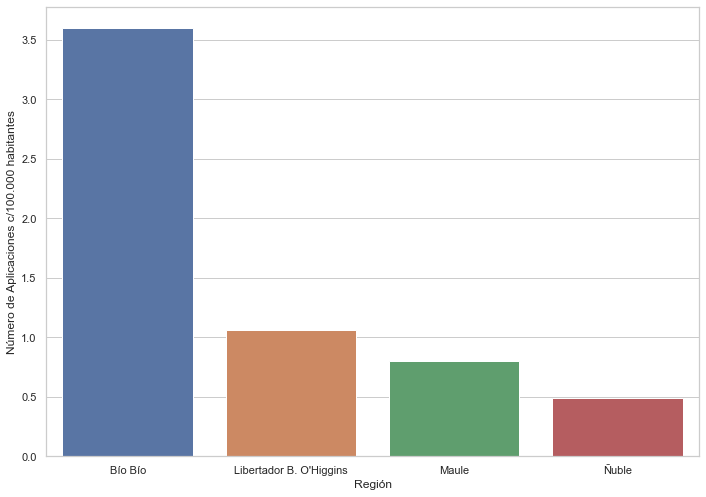

In [4]:
sns.set(rc={'figure.figsize':(11.7,8.27)}, style="whitegrid")
ax = sns.barplot(x="ApplicantRegion", y="Per Capita", data=df_agg)
ax.set_ylabel("Número de Aplicaciones c/100.000 habitantes")
ax.set_xlabel("Región")

In [5]:
#Se agrupan las solicitudes por solicitante y año, posteriormente obtenermos los solicitantes que por año realizaron más solicitudes

df_macrozone_top = df_macrozone

df_macrozone_top['Applicants'] = df_macrozone_top["Applicants"].str.upper().str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.replace(".", "")

stats2 = df_macrozone_top.groupby(["Applicants", "Year"]).agg({"ApplicationNumber": "nunique"}).reset_index()

df_top = stats2.sort_values('ApplicationNumber', ascending=False).head(20)





<ipython-input-5-48b6e9d9253b>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_macrozone_top['Applicants'] = df_macrozone_top["Applicants"].str.upper().str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.replace(".", "")


# Nuevo bloque de Luis, creación de funciones que retorna dataFrame de solicitantes o registros

In [6]:
#En caso de querer saber acerca de los colaboradores, comentar data.groupby... por:
#data = data.groupby(["Applicants", "Year"]).agg({"ApplicationNumber": "nunique"}).reset_index() 
#Esto aplica para registers y applicants

#Las instituciones con más solicitudes son 
#"UNIVERSIDAD DE CONCEPCION","UNIVERSIDAD DEL BIO BIO","CONTENEDORES SAN FERNANDO SPA", "MARIO GUERRERO MENDEZ", "VICTOR MANUEL ROSALES ITURRA"

def data_applicants(inst):
    data = df_macrozone2[df_macrozone2["Applicants"].str.contains(inst, regex=True, na=False)]
    data = data.groupby(["Year"]).agg({"ApplicationNumber": "nunique"}).reset_index()
    data = data.sort_values('Year', ascending=True)
    return data

def data_registers(inst):
    data = df_macrozone[df_macrozone["Applicants"].str.contains(inst, regex=True, na=False)]
    data = data.groupby(["Year"]).agg({"ApplicationNumber": "nunique"}).reset_index()
    data = data.sort_values('Year', ascending=True)
    return data
    
def merge_data(inst):
    merged = pd.merge(data_applicants(inst), data_registers(inst),  on=['Year'])
    merged = merged.rename(columns={'ApplicationNumber_x':'Applicants',
                                   'ApplicationNumber_y':'Applicants_Registers'})
    merged.insert(1, 'Applicant', inst, allow_duplicates=False)
    
    return merged
    

data_registers('UNIVERSIDAD DE CONCEPCION')

,Year,ApplicationNumber
0,2009,7
1,2010,10
2,2011,9
3,2012,13
4,2013,11
5,2014,27
6,2015,28
7,2016,25
8,2017,27
9,2018,19


In [7]:
data_applicants('UNIVERSIDAD DE CONCEPCION')

,Year,ApplicationNumber
0,1999,1
1,2000,2
2,2001,3
3,2002,1
4,2003,2
5,2004,6
6,2005,9
7,2006,2
8,2007,8
9,2008,6


In [18]:
#En merge_data usamos el parámetro que necesitamos de institucion: estos son por ejemplo
#"UNIVERSIDAD DE CONCEPCION","UNIVERSIDAD DEL BIO BIO","CONTENEDORES SAN FERNANDO SPA", "MARIO GUERRERO MENDEZ", "VICTOR MANUEL ROSALES ITURRA"
var = merge_data('UNIVERSIDAD DEL BIO BIO')
var
#Podríamos calcular tasas de aceptación, el problema es que si bien te acuerdas, los datos de los appicants desde el año 2013 en adelan te están incompletos
#Esto lo comprobamos ese día en donde vimos que en applicants de 2021 por ejemplo existen sólo 5 tuplas de datos

#La suma de los applicants y registers por año la comprobé y está correcta 
#Si quieres comprobarla debes añadir en la funcion agrupar que se agrupe por aplicant

,Year,Applicant,Applicants,Applicants_Registers
0,2012,UNIVERSIDAD DEL BIO BIO,1,1
1,2014,UNIVERSIDAD DEL BIO BIO,2,2
2,2015,UNIVERSIDAD DEL BIO BIO,3,4
3,2016,UNIVERSIDAD DEL BIO BIO,2,3
4,2017,UNIVERSIDAD DEL BIO BIO,8,9
5,2018,UNIVERSIDAD DEL BIO BIO,4,7
6,2019,UNIVERSIDAD DEL BIO BIO,2,7


In [19]:
#only merge universidad de concepcion
# do tidy data 


tidy = pd.melt(frame=var, id_vars=['Applicant','Year'],
               value_vars=['Applicants','Applicants_Registers'],
              var_name='Type', value_name='ApplicationNumber')
# idk if ApplicationNumber_x references to Register or Applicant, this is only a test to deploying data
def transform(aux):
    if (aux == 'Applicants_Registers'):
        return 'Register'
    return 'Applicant'

tidy['Type'] = tidy['Type'].apply(transform)

tidy

,Applicant,Year,Type,ApplicationNumber
0,UNIVERSIDAD DEL BIO BIO,2012,Applicant,1
1,UNIVERSIDAD DEL BIO BIO,2014,Applicant,2
2,UNIVERSIDAD DEL BIO BIO,2015,Applicant,3
3,UNIVERSIDAD DEL BIO BIO,2016,Applicant,2
4,UNIVERSIDAD DEL BIO BIO,2017,Applicant,8
5,UNIVERSIDAD DEL BIO BIO,2018,Applicant,4
6,UNIVERSIDAD DEL BIO BIO,2019,Applicant,2
7,UNIVERSIDAD DEL BIO BIO,2012,Register,1
8,UNIVERSIDAD DEL BIO BIO,2014,Register,2
9,UNIVERSIDAD DEL BIO BIO,2015,Register,4


In [20]:
alt.Chart(tidy).mark_bar().encode(
    x='Type:O',
    y='ApplicationNumber:Q',
    color='Type:N',
    column='Year:N'
)

alt.Chart(...)

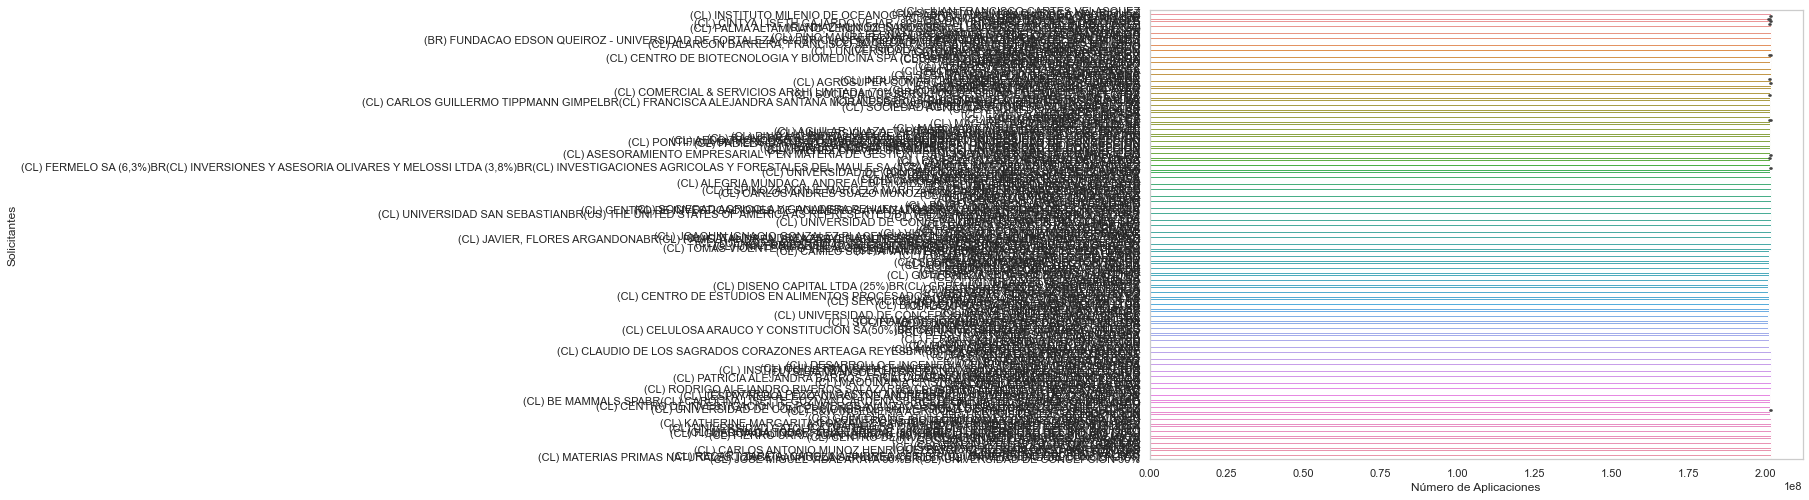

In [11]:
#using function to compare applications vs registers

# Too much data to deploy
grafico(df_macrozone)

In [12]:
# This cell have a several conflict with previous cells
#ubb_r.rename(columns={'ApplicationNumber':'ApplicationNumber_R'},
#               inplace=True)

#df_agg = df_agg.merge(df_population, on="ApplicantRegion")

#ubb = ubb.merge(ubb_r, on =  'Year')

### Gráficos de prueba
#### by fandi

# Esto es lo que falta, Acá la idea es que si puedes limpiar la data de los colaboradores eliminando los puntos, también setear los nombres de los applicants con registers para que sean iguales, posteriormente a eso podemos averiguar qué significa el BR

In [13]:
#Esto hasta ahora no lo usamos


from fuzzywuzzy import process
from fuzzywuzzy import fuzz

max=0;

#for i in array_applicants_data[0]['Applicants']:
#    for j in array_registers_data[0]['Applicants']:
#        x= fuzz.ratio(i,j)
#        if(x>max):
#            max = x
#            xmax= i
#            ymax = j        
        
#    print(max)
#    print(xmax)
#    print(ymax)



#Lo que quiero hacer acá, es comparar el nombre de cada uno de la lista de solicitantes (applicants)
#Para posteriormente compararlo con cada nombre de la lista de registros
#Se ingresa el primer nombre de solicitante y se remueve de la lista
#Posteriormente a la comparación con cada nombre de registro, se almacena el 
#Ratio más alto, y así mismo se almacena el nombre correspondiente a ese ratio
#Para posteriiormente eliminarlo de la lista y que no se siga comparando
#Así tendríamos cual nombre de solicitante corresponde con el registro y podríamos realizar correción de nombre

def similarity_Name(applicants,indx,registers):
    max = 0
    lista = applicants
    lista2 = registers
    array = list()
    for i in lista:
        sub_array = list()
        sub_array.append(i)
        lista.remove(i)
        for j in registers:
            x = fuzz.ratio(i,j)
            if(x > max):
                max = x
                ymax = j
        sub_array.append(ymax)  
        lista2.remove(ymax)        
        array.append(sub_array) 
    return array 



In [14]:
#Este gráfico ya no aplica debido a que este contenía a los colaboradores y esto es resultado de limpiar la data anterior, colabopradores, etc... 


# grouped bar chart
source = merged
alt.Chart(source).mark_bar().encode(
    x='Year:O',
    y='ApplicationNumber:Q',
    color='Applicants:N'
    #,column='Applicants:N'
)
# if we discriminate columns by applicants they might will be too much data to deploy

NameError: name 'merged' is not defined